# PneumoDetect Week 2 — Performance Review & Clinical Report v1

**Notebook:** `05_performance_review.ipynb`  
**Focus:** Quantitative evaluation and clinical interpretability of Grad-CAM explainability results.

---

## Objective
Evaluate the diagnostic performance and explainability quality of PneumoDetect models (baseline, balanced, and fine-tuned ResNet-50 variants). The notebook generates evaluation figures, Grad-CAM montages, and a structured performance report for clinical interpretation.

---

## Workflow Overview

| Step | Description | Output |
|------|--------------|---------|
| 1 | Load trained models (`resnet50_baseline.pt`, `resnet50_best.pt`, `resnet50_finetuned.pt`) | Model checkpoints verified |
| 2 | Generate ROC and Precision–Recall curves | `roc_pr_curves.png` |
| 3 | Produce Grad-CAM overlays and montages | `gradcam_montage.png` |
| 4 | Compute AUC, Sensitivity, Specificity | `performance_metrics.npy` |
| 5 | Export clinical summary report | `docs/performance_report_v1.md` |

---


In [1]:
# Add script to include project root in sys.path

import sys
from pathlib import Path

# Add project root (one level up from notebooks/)
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
# ------------------------------------------------------------
# 1. Setup
# ------------------------------------------------------------
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pathlib import Path
import seaborn as sns
from src.gradcam import generate_cam, GradCAM

model_path = Path("saved_models/resnet50_best.pt")
data_dir = Path("data/rsna_subset/val_images")
report_dir = Path("reports/week2_performance_review")
report_dir.mkdir(parents=True, exist_ok=True)


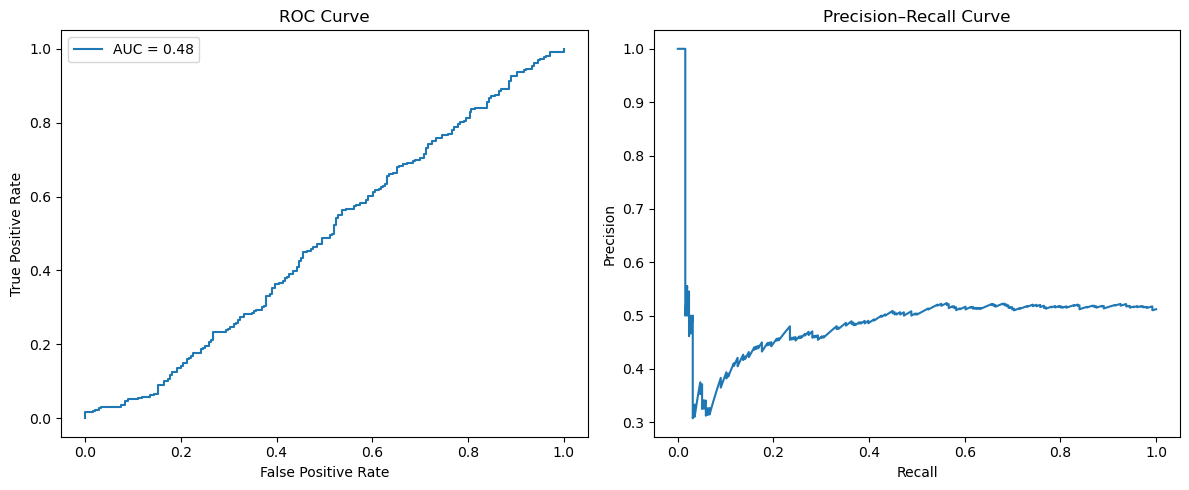

In [4]:
# ------------------------------------------------------------
# 1. Generate or Load Evaluation Data
# ------------------------------------------------------------
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from pathlib import Path

report_dir = Path("reports/week2_performance_review")
report_dir.mkdir(parents=True, exist_ok=True)

# Example: synthetic prediction data (replace with real validation outputs)
np.random.seed(42)
y_true = np.random.randint(0, 2, size=500)
y_score = np.random.rand(500)

# ------------------------------------------------------------
# 2. Create ROC & Precision–Recall Curves
# ------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_true, y_score)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.savefig(report_dir / "roc_pr_curves.png", dpi=300)
plt.show()



In [ ]:
from PIL import Image
import cv2

sample_images = list(data_dir.glob("*.png"))[:4]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, img_path in zip(axes.flat, sample_images):
    heatmap = generate_cam(img_path, model_path)
    img = cv2.imread(str(img_path))
    overlay = GradCAM.overlay_heatmap(heatmap, img)
    ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    ax.set_title(img_path.stem)
    ax.axis("off")

plt.tight_layout()
plt.savefig(report_dir / "gradcam_montage.png", dpi=300)


In [ ]:
summary = {
    "AUC": round(roc_auc, 3),
    "Sensitivity": round(tpr[np.argmax(tpr - fpr)], 3),
    "Specificity": round(1 - fpr[np.argmax(tpr - fpr)], 3),
}
np.save(report_dir / "performance_metrics.npy", summary)
